In [1]:
%load_ext line_profiler
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from collections import deque

from torchvision import transforms as T

import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
env = gym_super_mario_bros.make("SuperMarioBros-v0", render_mode='rgb_array', apply_api_compatibility=True)
env = JoypadSpace(env, SIMPLE_MOVEMENT)

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)

c:\Users\dan2972\miniconda3\envs\cs175\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
c:\Users\dan2972\miniconda3\envs\cs175\Lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
c:\Users\dan2972\miniconda3\envs\cs175\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [4]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

In [5]:
s_size = env.observation_space.shape
a_size = env.action_space.n
print(env.observation_space.shape, s_size, a_size)

(4, 84, 84) (4, 84, 84) 7


In [6]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        # Define the three layers here
        # Code Here
        self.cnn = self.__build_cnn(4, a_size, h_size)

    def forward(self, x):
        return self.cnn(x)

    def act(self, state):
        state = np.array(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

    def __build_cnn(self, c, output_dim, hidden_dim):
        return nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, hidden_dim),
            # nn.Flatten(),
            # nn.Linear(1296, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1)
        )

In [7]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    scores = []
    # Line 3 of pseudocode
    for episode in range(n_training_episodes):
        log_probs = []
        rewards = []
        state, _ = env.reset() # Code Here: reset the environment
        # Line 4 of pseudocode
        while True:
            action, log_prob = policy.act(state) # Code Here: get the action
            state, reward, done, truncated, info = env.step(action) # Code Here: take an env step
            
            log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                break
        scores.append(sum(rewards))

        # Compute returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns)

        ## standardization for training stability
        eps = np.finfo(np.float32).eps.item()

        ## eps is added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Policy gradient update
        policy_loss = []
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)
        policy_loss = torch.stack(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        print(f"Episode {episode+1}/{n_training_episodes}, Total Reward: {sum(rewards)}")

    return scores

In [8]:
mario_params = {
    "h_size": 512,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 100000,
    "gamma": 0.99,
    "lr": 1e-4, #0.00025
    "state_space": s_size,
    "action_space": a_size,
}

In [9]:
mario_policy = Policy(mario_params["state_space"], mario_params["action_space"], mario_params["h_size"]).to(device)
mario_optimizer = optim.Adam(mario_policy.parameters(), lr=mario_params["lr"])

In [10]:
# %lprun -f reinforce reinforce(mario_policy, mario_optimizer, mario_params["n_training_episodes"], mario_params["max_t"], mario_params["gamma"], 1)
scores = reinforce(mario_policy,
                   mario_optimizer,
                   mario_params["n_training_episodes"],
                   mario_params["max_t"],
                   mario_params["gamma"],
                   10)

c:\Users\dan2972\miniconda3\envs\cs175\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
C:\Users\dan2972\AppData\Local\Temp\ipykernel_27144\4172923039.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  

Episode 1/1000, Total Reward: 1532.0
Episode 2/1000, Total Reward: 1065.0
Episode 3/1000, Total Reward: 1622.0
Episode 4/1000, Total Reward: 1852.0
Episode 5/1000, Total Reward: 1502.0
Episode 6/1000, Total Reward: 2326.0
Episode 7/1000, Total Reward: 1039.0
Episode 8/1000, Total Reward: 1608.0
Episode 9/1000, Total Reward: 1411.0
Episode 10/1000, Total Reward: 1758.0
Episode 11/1000, Total Reward: 1127.0
Episode 12/1000, Total Reward: 1858.0
Episode 13/1000, Total Reward: 2186.0
Episode 14/1000, Total Reward: 1635.0
Episode 15/1000, Total Reward: 2117.0
Episode 16/1000, Total Reward: 2297.0
Episode 17/1000, Total Reward: 1811.0
Episode 18/1000, Total Reward: 978.0
Episode 19/1000, Total Reward: 1511.0
Episode 20/1000, Total Reward: 1263.0
Episode 21/1000, Total Reward: 1789.0
Episode 22/1000, Total Reward: 1468.0
Episode 23/1000, Total Reward: 1044.0
Episode 24/1000, Total Reward: 1423.0
Episode 25/1000, Total Reward: 2402.0
Episode 26/1000, Total Reward: 2138.0
Episode 27/1000, Total

In [11]:
def record_video(env, policy, out_directory, fps=30, max_frames = 1000):
  images = []
  done = False
  state, _ = env.reset()
  frame_counter = 0
  while not done and frame_counter < max_frames:
    action, _ = policy.act(state)
    state, reward, done, tunc, info = env.step(action)
    img = env.render()
    x = img.copy()
    images.append(x)
    frame_counter += 1
  imageio.mimsave(out_directory, [np.array(img) for img in images], fps=fps)

In [12]:
record_video(env, mario_policy, './replay.mp4', 30)

c:\Users\dan2972\miniconda3\envs\cs175\Lib\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


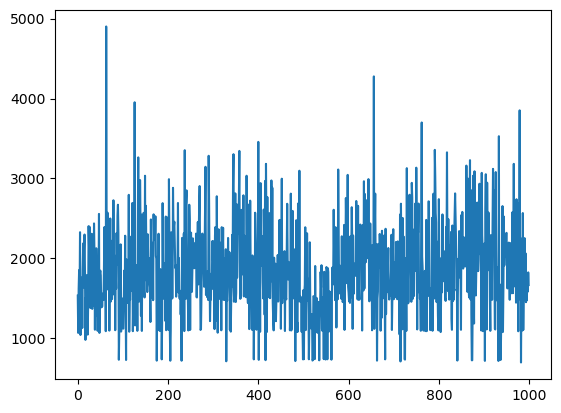

In [13]:
plt.plot(scores)